In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import sys
import os
import time


In [2]:
batch_size = 16
img_height = 500
img_width = 500

In [3]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(img_width,img_height,1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(img_width,img_height,1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(img_width,img_height,1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(img_width,img_height,1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(img_width,img_height,1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(activation='relu', units=128))
model.add(Dense(activation='relu', units=64))
model.add(Dense(activation='sigmoid', units=1))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [4]:
output_id = int(time.time())
os.mkdir(f'./model_training/{output_id}')
output_file_name = f'./model_training/{output_id}/output.txt'
output_file = open(output_file_name, 'w+')
orig_stdout = sys.stdout
sys.stdout = output_file

In [5]:
model.summary()

In [9]:
train_datagen = image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = image.ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(
    'train',
    target_size=(img_height,img_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size)

validation_generator = test_datagen.flow_from_directory(
    'test',
    target_size=(img_height,img_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size)

In [6]:
early = EarlyStopping(monitor='val_loss', mode='min', patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.3, min_lr=0.000001)
callbacks_list = [early, learning_rate_reduction]

In [11]:
weights = compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)
cw = dict(zip(np.unique(train_generator.classes), weights))
print(cw)

In [12]:
hist = model.fit(
    train_generator,
    epochs = 25,
    class_weight=cw,
    validation_data=validation_generator)

In [13]:
sys.stdout = orig_stdout
output_file.close()

In [14]:
loss_png_file = open(f'./model_training/{output_id}/loss.png', 'w')
sys.stdout = loss_png_file

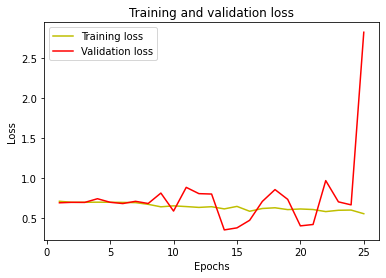

In [15]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(sys.stdout.buffer)

In [16]:
loss_png_file.close()
sys.stdout = orig_stdout

In [17]:
acc_png_file = open(f'./model_training/{output_id}/accuracy.png', 'w')
sys.stdout = acc_png_file

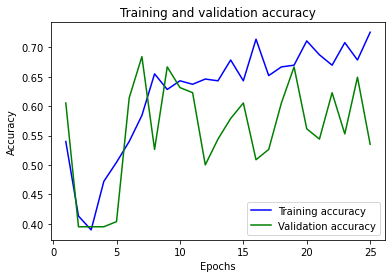

In [18]:
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, 'blue', label='Training accuracy')
plt.plot(epochs, val_acc, 'green', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(sys.stdout.buffer)


In [19]:
acc_png_file.close()
sys.stdout = orig_stdout

In [ ]:
model.save('covid_cnn.h5py')